# Deep Learning and Its Applications to Signal and Image Processing and Analysis - Assignment 3
# Yarden Cohen, Id 209496132


## Introduction
In this assignment, you will perform an image classification task on the CIFAR-10 dataset using two
model families: Convolutional Neural Networks (CNNs) and Vision Transformers (ViTs). The objectives
are to develop models, apply explainability tools (Grad-CAM and attention visualization), and evaluate
comparative performance using confusion matrices and other metrics. In this assignment, you will also
learn how to use the pytorch-lightning library. This library simplifies model building and training, and
it also supports automatic logging to Weights & Biases. There is a complementary notebook attached
to the assignment. A complementary notebook is provided with this assignment. It is intended for your
convenience, and you are free to modify it as needed.

### Imports and mount drive

In [ ]:

# 📦 Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

import wandb

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

# 🧹 Set seeds and configs
pl.seed_everything(42)

Seed set to 42


42

## 1. CNN Classification and Grad-CAM Explainability

In this section, you will implement a CNN from scratch and apply Grad-CAM to explain the model predictions.

###  1.1. Load and Preprocess CIFAR-10

a.

Files already downloaded and verified
Files already downloaded and verified


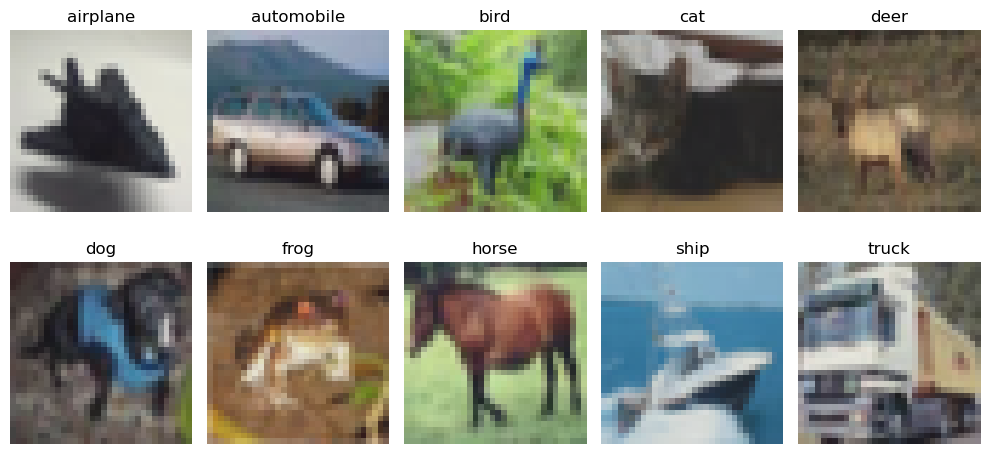

In [ ]:
# Define a transform to normalize the data
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.247, 0.2435, 0.2616])
])

#⬇️ Load dataset
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

class_names = dataset.classes

def show_example_per_label(dataset):
    """Show one example image per label from the dataset."""
    labels_map = dataset.classes
    shown_labels = set()
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    axes = axes.flatten()

    for image_tensor, label in dataset:
        if label not in shown_labels:
            ax = axes[label]
            ax.imshow(image_tensor.permute(1, 2, 0) * torch.tensor([0.2023, 0.1994, 0.2010]) + torch.tensor([0.4914, 0.4822, 0.4465]))  # de-normalize
            ax.set_title(labels_map[label])
            ax.axis('off')
            shown_labels.add(label)
        if len(shown_labels) == 10:
            break

    plt.tight_layout()
    plt.show()



show_example_per_label(dataset)



In [4]:
# Print dataset information

print(f"Dataset size: {len(dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Number of classes: {len(dataset.classes)}")
print(f"Dataset type: {type(dataset)}\n")

#print intput images shape
print(f"Input image shape: {dataset[0][0].shape}")
print(f"Input image type: {type(dataset[0][0])}\n")

# print the number of sample per class
print("Number of samples per class:")
for i in range(len(dataset.classes)):
    print(f"{dataset.classes[i]}: {len([x for x in dataset.targets if x == i])}")

Dataset size: 50000
Test dataset size: 10000
Number of classes: 10
Dataset type: <class 'torchvision.datasets.cifar.CIFAR10'>

Input image shape: torch.Size([3, 32, 32])
Input image type: <class 'torch.Tensor'>

Number of samples per class:
airplane: 5000
automobile: 5000
bird: 5000
cat: 5000
deer: 5000
dog: 5000
frog: 5000
horse: 5000
ship: 5000
truck: 5000


b.

In [15]:
dataset, type(dataset.data), dataset.data.shape, dataset.data[0].shape, type(dataset.targets)

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.2435, 0.2616])
            ),
 numpy.ndarray,
 (50000, 32, 32, 3),
 (32, 32, 3),
 list)

In [36]:
# Split the database into train, validation and test data set.
def split_dataset(dataset, val_size=0.2):

    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

    # Perform the split
    for train_idx, val_idx in splitter.split(dataset.data, dataset.targets):
        train_dataset = torch.utils.data.Subset(dataset, train_idx)
        val_dataset = torch.utils.data.Subset(dataset, val_idx)

    return train_dataset, val_dataset

batch_size = 64

train_dataset, val_dataset = split_dataset(dataset, val_size=0.2)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

c.

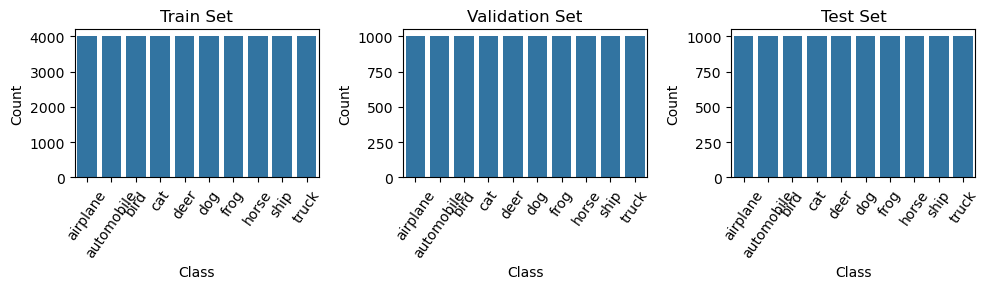

In [37]:
# Show histogram of the categorical split for train, validation and test.
def plot_class_distribution(datasets, labels):
    """Plot histograms of class distributions for given datasets."""
    class_names = datasets[0].dataset.classes if isinstance(datasets[0], torch.utils.data.Subset) else datasets[0].classes
    num_classes = len(class_names)

    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    for ax, ds, label in zip(axes, datasets, labels):
        if isinstance(ds, torch.utils.data.Subset):
            targets = [ds.dataset.targets[i] for i in ds.indices]
        else:
            targets = ds.targets

        sns.countplot(x=targets, ax=ax)
        ax.set_title(f"{label} Set")
        ax.set_xlabel("Class")
        ax.set_ylabel("Count")
        ax.set_xticks(range(num_classes))
        ax.set_xticklabels(class_names, rotation=55)

    plt.tight_layout()
    plt.show()

# Call the function
plot_class_distribution([train_dataset, val_dataset, test_dataset], ["Train", "Validation", "Test"])

###  1.2. Define CNN in PyTorch Lightning

a.

In [ ]:
class SimpleCNN(pl.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.lr = lr
        self.test_preds = []
        self.test_targets = []
        self.class_names = class_names
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Dropout(0.5)
        )

        self.classifier = nn.Linear(256, 10)
        self.criterion = nn.CrossEntropyLoss()


    def forward(self, x):
        x = self.model(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        preds = logits.argmax(dim=1)
        acc = (logits.argmax(dim=1) == y).float().mean()

        self.test_preds.extend(preds.cpu().numpy())
        self.test_targets.extend(y.cpu().numpy())

        self.log("test_loss", loss)
        self.log("test_acc", acc)



    def on_test_epoch_end(self):

        # Confusion Matrix
        cm = confusion_matrix(self.test_targets, self.test_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.class_names)
        fig, ax = plt.subplots(figsize=(10, 8))
        disp.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.Blues)
        plt.title("Confusion Matrix - Test Set")
        
        confusion_matrix_path = "confusion_matrix.png"
        plt.savefig(confusion_matrix_path)
        plt.show()
        plt.close()  
        
        # Log the saved image
        try:
            wandb.log({"confusion_matrix": wandb.Image(confusion_matrix_path)})
        except Exception as e:
            print(f"Error logging confusion matrix: {e}")
        
        # Classification Report
        print("Classification Report:")
        report = classification_report(self.test_targets, self.test_preds, target_names=self.class_names)
        print(report)
        
        try:
            # Log the classification report as a dictionary
            report_dict = classification_report(self.test_targets, self.test_preds, 
                                            target_names=self.class_names, output_dict=True)
            metrics = {}
            for class_name in self.class_names:
                metrics[f"f1_{class_name}"] = report_dict[class_name]['f1-score']
                metrics[f"precision_{class_name}"] = report_dict[class_name]['precision']
                metrics[f"recall_{class_name}"] = report_dict[class_name]['recall']
            
            # Log overall metrics
            metrics["accuracy"] = report_dict["accuracy"]
            metrics["macro_f1"] = report_dict["macro avg"]["f1-score"]
            metrics["weighted_f1"] = report_dict["weighted avg"]["f1-score"]
            
            wandb.log(metrics)
        except Exception as e:
            print(f"Error logging classification report: {e}")

        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

b. Your model should achieve an accuracy of at least 0.80 on the training set, and at least 0.70 on both the validation and test sets.

In [ ]:
# 🪄 Init wandb logger 
wandb_logger = WandbLogger(project="CNN-CIFAR10", log_model=True, name = "Run-1")

# ⚡ Instantiate model and trainer
model = SimpleCNN(lr=1e-3)

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",
    mode="max",
    save_top_k=1,
    filename="cnn-best-{epoch:02d}-{val_acc:.2f}",
    save_weights_only=True,
    verbose=True
)

trainer = pl.Trainer(
    max_epochs=60,
    logger=wandb_logger,
    callbacks=[checkpoint_callback],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    strategy="auto",
    log_every_n_steps=10
)

# Train
trainer.fit(model, train_loader, val_loader)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | Sequential       | 556 K  | train
1 | classifier | Linear           | 2.6 K  | train
2 | criterion  | CrossEntropyLoss | 0      | train
--------------------------------------------------------
559 K     Trainable params
0         Non-trainable params
559 K     Total params
2.237     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\97252\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\97252\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 625: 'val_acc' reached 0.49270 (best 0.49270), saving model to '.\\CNN-CIFAR10\\t56u7v6y\\checkpoints\\cnn-best-epoch=00-val_acc=0.49.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 1250: 'val_acc' reached 0.53980 (best 0.53980), saving model to '.\\CNN-CIFAR10\\t56u7v6y\\checkpoints\\cnn-best-epoch=01-val_acc=0.54.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 1875: 'val_acc' reached 0.58510 (best 0.58510), saving model to '.\\CNN-CIFAR10\\t56u7v6y\\checkpoints\\cnn-best-epoch=02-val_acc=0.59.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 2500: 'val_acc' reached 0.62580 (best 0.62580), saving model to '.\\CNN-CIFAR10\\t56u7v6y\\checkpoints\\cnn-best-epoch=03-val_acc=0.63.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 3125: 'val_acc' reached 0.66110 (best 0.66110), saving model to '.\\CNN-CIFAR10\\t56u7v6y\\checkpoints\\cnn-best-epoch=04-val_acc=0.66.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 3750: 'val_acc' reached 0.66480 (best 0.66480), saving model to '.\\CNN-CIFAR10\\t56u7v6y\\checkpoints\\cnn-best-epoch=05-val_acc=0.66.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 4375: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 5000: 'val_acc' reached 0.68600 (best 0.68600), saving model to '.\\CNN-CIFAR10\\t56u7v6y\\checkpoints\\cnn-best-epoch=07-val_acc=0.69.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 5625: 'val_acc' reached 0.72690 (best 0.72690), saving model to '.\\CNN-CIFAR10\\t56u7v6y\\checkpoints\\cnn-best-epoch=08-val_acc=0.73.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 6250: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 6875: 'val_acc' reached 0.73450 (best 0.73450), saving model to '.\\CNN-CIFAR10\\t56u7v6y\\checkpoints\\cnn-best-epoch=10-val_acc=0.73.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 7500: 'val_acc' reached 0.74100 (best 0.74100), saving model to '.\\CNN-CIFAR10\\t56u7v6y\\checkpoints\\cnn-best-epoch=11-val_acc=0.74.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 8125: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 8750: 'val_acc' reached 0.75660 (best 0.75660), saving model to '.\\CNN-CIFAR10\\t56u7v6y\\checkpoints\\cnn-best-epoch=13-val_acc=0.76.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 9375: 'val_acc' reached 0.76100 (best 0.76100), saving model to '.\\CNN-CIFAR10\\t56u7v6y\\checkpoints\\cnn-best-epoch=14-val_acc=0.76.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 10000: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 10625: 'val_acc' reached 0.76970 (best 0.76970), saving model to '.\\CNN-CIFAR10\\t56u7v6y\\checkpoints\\cnn-best-epoch=16-val_acc=0.77.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 11250: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 11875: 'val_acc' reached 0.78580 (best 0.78580), saving model to '.\\CNN-CIFAR10\\t56u7v6y\\checkpoints\\cnn-best-epoch=18-val_acc=0.79.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 12500: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 13125: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 13750: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 14375: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 15000: 'val_acc' reached 0.80040 (best 0.80040), saving model to '.\\CNN-CIFAR10\\t56u7v6y\\checkpoints\\cnn-best-epoch=23-val_acc=0.80.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 15625: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 16250: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 16875: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 17500: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 18125: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 18750: 'val_acc' reached 0.80490 (best 0.80490), saving model to '.\\CNN-CIFAR10\\t56u7v6y\\checkpoints\\cnn-best-epoch=29-val_acc=0.80.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 19375: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 20000: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 20625: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 21250: 'val_acc' reached 0.80550 (best 0.80550), saving model to '.\\CNN-CIFAR10\\t56u7v6y\\checkpoints\\cnn-best-epoch=33-val_acc=0.81.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 21875: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35, global step 22500: 'val_acc' reached 0.80590 (best 0.80590), saving model to '.\\CNN-CIFAR10\\t56u7v6y\\checkpoints\\cnn-best-epoch=35-val_acc=0.81.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36, global step 23125: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37, global step 23750: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38, global step 24375: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39, global step 25000: 'val_acc' was not in top 1
`Trainer.fit` stopped: `max_epochs=40` reached.


c.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\97252\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

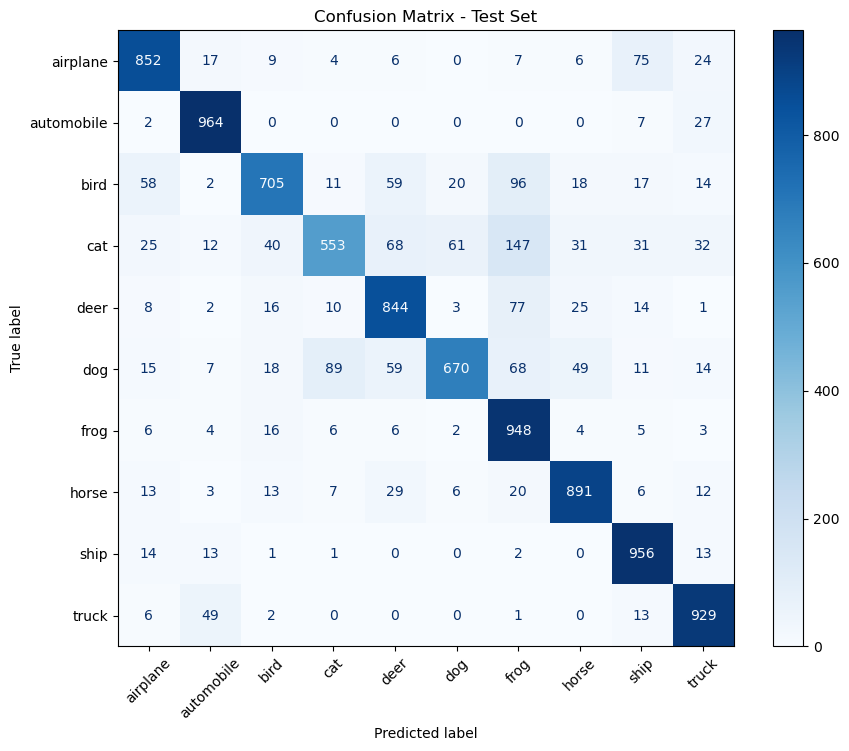

Classification Report:
              precision    recall  f1-score   support

    airplane       0.85      0.85      0.85      1000
  automobile       0.90      0.96      0.93      1000
        bird       0.86      0.70      0.77      1000
         cat       0.81      0.55      0.66      1000
        deer       0.79      0.84      0.82      1000
         dog       0.88      0.67      0.76      1000
        frog       0.69      0.95      0.80      1000
       horse       0.87      0.89      0.88      1000
        ship       0.84      0.96      0.90      1000
       truck       0.87      0.93      0.90      1000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8312000036239624     │
│         test_loss         │    0.5049616098403931     │
└───────────────────────────┴───────────────────────────┘

In [35]:
# 🔍 Evaluate
trainer.test(model, dataloaders=test_loader)

# 💾 Save the model in thr last epoch if saved by metric  
torch.save(model.state_dict(), "cnn_cifar10_checkpoint.ckpt")

## 1.3 Explainability with Grad-CAM

a.

In [58]:
model.model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.25, inplace=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Dropout(p=0.25, inplace=False)
  (16): Conv2d(128, 256, kernel_size=(3, 3

In [60]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Define the target layer for Grad-CAM (adjust if needed)
target_layer = model.model[16]  

cam = GradCAM(model=model, target_layers=[target_layer])


generate Grad-CAM heatmaps for several test images

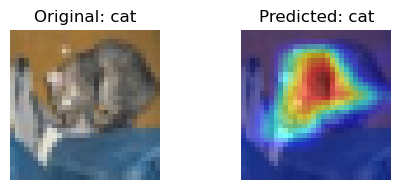

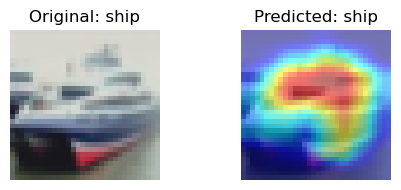

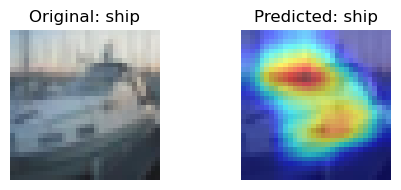

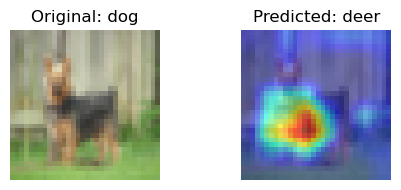

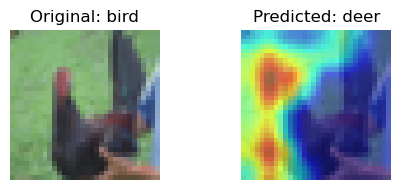

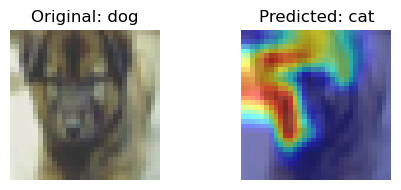

In [61]:
# generate Grad-CAM heatmaps for several test image

def generate_gradcam_heatmaps(model, dataloader, target_layer, class_names, num_images=5, wrong_only = False, correct_only = False):
    model.eval()

    cam = GradCAM(model=model, target_layers=[target_layer])

    images_shown = 0
    for images, labels in dataloader:
        for img_tensor, label in zip(images, labels):
            # Original image
            rgb_img = img_tensor.permute(1, 2, 0).numpy()
            rgb_img = (rgb_img * np.array([0.2023, 0.1994, 0.2010])) + np.array([0.4914, 0.4822, 0.4465])
            rgb_img = np.clip(rgb_img, 0, 1)

            input_tensor = img_tensor.unsqueeze(0).to(model.device)

            # Prediction
            logits = model(input_tensor)
            pred_idx = logits.argmax(dim=1).item()

            
            if pred_idx != label.item():
                if not correct_only:
                    targets = [ClassifierOutputTarget(label.item())]
                    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
                    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

                    # Plot
                    fig, ax = plt.subplots(1, 2, figsize=(5, 2))
                    ax[0].imshow(rgb_img)
                    ax[0].set_title(f"Original: {class_names[label.item()]}")
                    ax[0].axis('off')
                    ax[1].imshow(cam_image)
                    ax[1].set_title(f"Predicted: {class_names[pred_idx]}")
                    ax[1].axis('off')
                    plt.tight_layout()
                    plt.show()

                    images_shown += 1
            

            
            else:
                if not wrong_only:
                    targets = [ClassifierOutputTarget(label.item())]
                    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
                    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

                    # Plot
                    fig, ax = plt.subplots(1, 2, figsize=(5, 2))
                    ax[0].imshow(rgb_img)
                    ax[0].set_title(f"Original: {class_names[label.item()]}")
                    ax[0].axis('off')
                    ax[1].imshow(cam_image)
                    ax[1].set_title(f"Predicted: {class_names[pred_idx]}")
                    ax[1].axis('off')
                    plt.tight_layout()
                    plt.show()

                    images_shown += 1


                
            if images_shown >= num_images:
                    return




generate_gradcam_heatmaps(model, test_loader, target_layer, class_names, num_images=3, correct_only=True)
generate_gradcam_heatmaps(model, test_loader, target_layer, class_names, num_images=3, wrong_only=True)

## 2. Vision Transformer (ViT) and Attention Visualization


In this section, you will implement a Vision Transformer (ViT) from scratch and compare it to the CNN
model developed in Section 1. Additionally, you will visualize attention maps to gain insight into the
model’s decision process.

### 2.1 Implementing the Vision Transformer

a.

In [ ]:

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=4, emb_size=192, img_size=32):
        super().__init__()
        
        self.patch_size = patch_size
        self.emb_size = emb_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.LayerNorm(emb_size)
    
    def forward(self, x):
        # Reshape and project
        x = self.proj(x)  # (B, E, H', W')
        x = x.flatten(2)  # (B, E, N)
        x = x.transpose(1, 2)  # (B, N, E)
        
        # Apply normalization
        x = self.norm(x)
        
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size=192, num_heads=8, dropout=0.1):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.head_dim = emb_size // num_heads
        assert self.head_dim * num_heads == emb_size, f"Embedding size must be divisible by num_heads"
        
        self.qkv = nn.Linear(emb_size, 3 * emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        self.projection_drop = nn.Dropout(dropout)
        
    def forward(self, x, return_attention=False):
        # x shape: (B, N, E)
        batch_size, seq_len, _ = x.shape
        
        # Get query, key, value projections
        qkv = self.qkv(x).reshape(batch_size, seq_len, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, B, H, N, D)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Each: (B, H, N, D)
        
        # Calculate attention
        k_t = k.transpose(-2, -1)  # (B, H, D, N)
        dots = (q @ k_t) / math.sqrt(self.head_dim)  # (B, H, N, N)
        attn = F.softmax(dots, dim=-1) 
        attn_weights = attn  # Save attention weights for visualizations
        attn = self.att_drop(attn)
        
        # Apply attention
        out = attn @ v  # (B, H, N, D)
        out = out.transpose(1, 2).contiguous() # (B, N, H, D)
        out = out.view(batch_size, seq_len, self.emb_size) # (B, N, E)
        out = self.projection(out) # (B, N, E)
        out = self.projection_drop(out)
        
        if return_attention:
            return out, attn_weights
        else:
            return out

class MLP(nn.Module):
    """MLP block for Transformer"""
    def __init__(self, emb_size=192, expansion_factor=4, dropout=0.1):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(emb_size, expansion_factor * emb_size),
            nn.GELU(),  # GELU activation as in the ViT paper
            nn.Dropout(dropout),
            nn.Linear(expansion_factor * emb_size, emb_size),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        return self.net(x)

class EncoderBlock(nn.Module):
    def __init__(self, emb_size=192, num_heads=8, dropout=0.1, expansion_factor=4):
        super().__init__()
        
        self.norm1 = nn.LayerNorm(emb_size)
        self.attn = MultiHeadAttention(emb_size, num_heads, dropout)
        self.norm2 = nn.LayerNorm(emb_size)
        self.mlp = MLP(emb_size, expansion_factor, dropout)
    
    def forward(self, x, return_attention=False):

        norm_x = self.norm1(x) # pre norm

        if return_attention:
            attn_output, attn_weights = self.attn(norm_x, return_attention=True)
            x = x + attn_output
        else:
            x = x + self.attn(norm_x)

        x = x + self.mlp(self.norm2(x))   
        
        if return_attention:
            return x,attn_weights
        else:
            return x

class ViTWithAttention(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, num_classes=10, 
                 emb_size=192, depth=8, num_heads=8, dropout=0.1):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.n_patches = (img_size // patch_size) ** 2
        
        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_size))
        self.pos_embedding = nn.Parameter(torch.zeros(1, 1 + self.n_patches, emb_size))
        
        # Patch embedding
        self.patch_embed = PatchEmbedding(in_channels, patch_size, emb_size, img_size)
        
        # Dropout after position embedding
        self.pos_drop = nn.Dropout(dropout)
        
        # Transformer Encoder Blocks
        self.blocks = nn.ModuleList([
            EncoderBlock(emb_size, num_heads, dropout, expansion_factor=4)
            for _ in range(depth)
        ])
        
        # Final layer norm
        self.norm = nn.LayerNorm(emb_size)
        
        # Classifier head
        self.classifier = nn.Linear(emb_size, num_classes)
        


    def forward(self, x, return_attention=False):
        B = x.shape[0]
        
        # Patch embedding
        x = self.patch_embed(x)  # (B, N, E)
        
        # Add CLS token and positional encoding
        cls_token = self.cls_token.expand(B, -1, -1)  # (B, 1, E)
        x = torch.cat([cls_token, x], dim=1)  # (B, 1+N, E)
        x = x + self.pos_embedding  
        x = self.pos_drop(x)  
        
        # Collect attention weights if requested
        attentions = []

        # Apply transformer blocks
        for block in self.blocks:
            if return_attention:
                x, attn_weights = block(x, return_attention=True)
                attentions.append(attn_weights)
            else:
                x = block(x)
        
        x = self.norm(x)
        logits = self.classifier(x[:, 0])
        
        if return_attention:
            return logits, attentions
        else:
            return logits

class ViTLightningModule(pl.LightningModule):
    def __init__(self, lr=5e-4, weight_decay=0.05, 
                 img_size=32, patch_size=4, emb_size=192, depth=8, num_heads=8, dropout=0.1):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = ViTWithAttention(
            img_size=img_size,
            patch_size=patch_size,
            emb_size=emb_size,
            depth=depth,
            num_heads=num_heads,
            dropout=dropout
        )
        
        self.lr = lr
        self.weight_decay = weight_decay

        
        # For confusion matrix visualization
        self.test_preds = []
        self.test_targets = []
        self.class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                           'dog', 'frog', 'horse', 'ship', 'truck']  # CIFAR-10 classes

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        
        # Log more detailed metrics
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        
        self.log("val_loss", loss, prog_bar=True, sync_dist=True)
        self.log("val_acc", acc, prog_bar=True, sync_dist=True)
        
        return {"val_loss": loss, "val_acc": acc}

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = logits.argmax(dim=1)
        acc = (preds == y).float().mean()
        
        # Save predictions for confusion matrix
        self.test_preds.extend(preds.cpu().numpy())
        self.test_targets.extend(y.cpu().numpy())
        
        self.log("test_loss", loss, sync_dist=True)
        self.log("test_acc", acc, sync_dist=True)
        
        return {"test_loss": loss, "test_acc": acc}


    def on_test_epoch_end(self):
        # Confusion Matrix
        cm = confusion_matrix(self.test_targets, self.test_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.class_names)
        fig, ax = plt.subplots(figsize=(8, 6))
        disp.plot(cmap=plt.cm.Blues, ax=ax)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
        plt.title("Confusion Matrix - Test Set")
        
        confusion_matrix_path = "confusion_matrix.png"
        plt.savefig(confusion_matrix_path)
        plt.show()
        plt.close()  

        try:
            wandb.log({"confusion_matrix": wandb.Image(confusion_matrix_path)})
        except Exception as e:
            print(f"Error logging confusion matrix: {e}")
        
        
        # Classification Report
        print("Classification Report:")
        report = classification_report(self.test_targets, self.test_preds, target_names=self.class_names)
        print(report)
        
        # Log classification metrics
        try:
            report_dict = classification_report(self.test_targets, self.test_preds, 
                                            target_names=self.class_names, output_dict=True)
            metrics = {}
            for class_name in self.class_names:
                metrics[f"f1_{class_name}"] = report_dict[class_name]['f1-score']
                metrics[f"precision_{class_name}"] = report_dict[class_name]['precision']
                metrics[f"recall_{class_name}"] = report_dict[class_name]['recall']
            
            # Log overall metrics
            metrics["accuracy"] = report_dict["accuracy"]
            metrics["macro_f1"] = report_dict["macro avg"]["f1-score"]
            metrics["weighted_f1"] = report_dict["weighted avg"]["f1-score"]
            
            if wandb.run is not None:
                wandb.log(metrics)
        except Exception as e:
            print(f"Error logging classification report: {e}")
        
        # Reset collections for next test epoch
        self.test_preds = []
        self.test_targets = []



    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.lr, weight_decay=0.1)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, 
            milestones=[10, 20, 30], 
            gamma=0.2  
        )
        return [optimizer], [lr_scheduler]




b. Your model should achieve an accuracy of at least 0.70 on the training set, and at least 0.60 on both the validation and test sets.

In [ ]:

run = 1

# Init wandb logger
wandb_logger = WandbLogger(project="ViT-CIFAR10-Improved", log_model=True, name=f"Run-{run}")


model = ViTLightningModule(
    lr=5e-4,          
    weight_decay=0.1,    
    warmup_steps=1000,   
    emb_size=192,           
    depth=6,                
    num_heads=6,            
    dropout=0.2           
)

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",
    mode="max",
    save_top_k=1,
    filename="vit-best-run-{run:02d}-{epoch:02d}-{val_acc:.4f}",
    save_weights_only=True,
    verbose=True
)


trainer = pl.Trainer(
    max_epochs=50,              # Train longer
    logger=wandb_logger,
    callbacks=[checkpoint_callback],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    strategy="auto",
    log_every_n_steps=10,
    gradient_clip_val=1.0,      
    precision="16-mixed" if torch.cuda.is_available() else 32  
)

# Train
trainer.fit(model, train_loader, val_loader)




accuracy,▁█
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
f1_airplane,▁█
f1_automobile,▁█
f1_bird,▁█
f1_cat,▁█
f1_deer,▁█
f1_dog,▁█
f1_frog,▁█
f1_horse,▁█
f1_ship,▁█


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | ViTWithAttention | 2.7 M  | train
---------------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.776    Total estimated model params size (MB)
98        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\97252\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\97252\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 625: 'val_acc' reached 0.46400 (best 0.46400), saving model to '.\\ViT-CIFAR10-Improved\\bmabre3p\\checkpoints\\vit-best-run-run=00-epoch=00-val_acc=0.4640.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 1250: 'val_acc' reached 0.52970 (best 0.52970), saving model to '.\\ViT-CIFAR10-Improved\\bmabre3p\\checkpoints\\vit-best-run-run=00-epoch=01-val_acc=0.5297.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 1875: 'val_acc' reached 0.55230 (best 0.55230), saving model to '.\\ViT-CIFAR10-Improved\\bmabre3p\\checkpoints\\vit-best-run-run=00-epoch=02-val_acc=0.5523.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 2500: 'val_acc' reached 0.58960 (best 0.58960), saving model to '.\\ViT-CIFAR10-Improved\\bmabre3p\\checkpoints\\vit-best-run-run=00-epoch=03-val_acc=0.5896.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 3125: 'val_acc' reached 0.59650 (best 0.59650), saving model to '.\\ViT-CIFAR10-Improved\\bmabre3p\\checkpoints\\vit-best-run-run=00-epoch=04-val_acc=0.5965.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 3750: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 4375: 'val_acc' reached 0.61880 (best 0.61880), saving model to '.\\ViT-CIFAR10-Improved\\bmabre3p\\checkpoints\\vit-best-run-run=00-epoch=06-val_acc=0.6188.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 5000: 'val_acc' reached 0.63800 (best 0.63800), saving model to '.\\ViT-CIFAR10-Improved\\bmabre3p\\checkpoints\\vit-best-run-run=00-epoch=07-val_acc=0.6380.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 5625: 'val_acc' reached 0.64320 (best 0.64320), saving model to '.\\ViT-CIFAR10-Improved\\bmabre3p\\checkpoints\\vit-best-run-run=00-epoch=08-val_acc=0.6432.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 6250: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 6875: 'val_acc' reached 0.68670 (best 0.68670), saving model to '.\\ViT-CIFAR10-Improved\\bmabre3p\\checkpoints\\vit-best-run-run=00-epoch=10-val_acc=0.6867.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 7500: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 8125: 'val_acc' reached 0.69570 (best 0.69570), saving model to '.\\ViT-CIFAR10-Improved\\bmabre3p\\checkpoints\\vit-best-run-run=00-epoch=12-val_acc=0.6957.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 8750: 'val_acc' reached 0.69580 (best 0.69580), saving model to '.\\ViT-CIFAR10-Improved\\bmabre3p\\checkpoints\\vit-best-run-run=00-epoch=13-val_acc=0.6958.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 9375: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 10000: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 10625: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 11250: 'val_acc' reached 0.69790 (best 0.69790), saving model to '.\\ViT-CIFAR10-Improved\\bmabre3p\\checkpoints\\vit-best-run-run=00-epoch=17-val_acc=0.6979.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 11875: 'val_acc' reached 0.69870 (best 0.69870), saving model to '.\\ViT-CIFAR10-Improved\\bmabre3p\\checkpoints\\vit-best-run-run=00-epoch=18-val_acc=0.6987.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 12500: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 13125: 'val_acc' reached 0.70480 (best 0.70480), saving model to '.\\ViT-CIFAR10-Improved\\bmabre3p\\checkpoints\\vit-best-run-run=00-epoch=20-val_acc=0.7048.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 13750: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 14375: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 15000: 'val_acc' reached 0.70700 (best 0.70700), saving model to '.\\ViT-CIFAR10-Improved\\bmabre3p\\checkpoints\\vit-best-run-run=00-epoch=23-val_acc=0.7070.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 15625: 'val_acc' reached 0.70740 (best 0.70740), saving model to '.\\ViT-CIFAR10-Improved\\bmabre3p\\checkpoints\\vit-best-run-run=00-epoch=24-val_acc=0.7074.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 16250: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 16875: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 17500: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 18125: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 18750: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 19375: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 20000: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 20625: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 21250: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 21875: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35, global step 22500: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36, global step 23125: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37, global step 23750: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38, global step 24375: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39, global step 25000: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40, global step 25625: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41, global step 26250: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42, global step 26875: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43, global step 27500: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44, global step 28125: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45, global step 28750: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46, global step 29375: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47, global step 30000: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48, global step 30625: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49, global step 31250: 'val_acc' was not in top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


c.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\97252\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

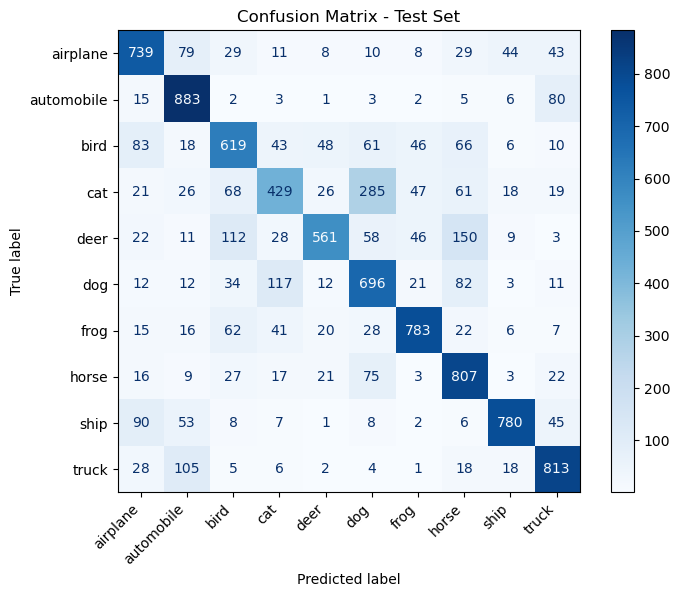

Classification Report:
              precision    recall  f1-score   support

    airplane       0.71      0.74      0.72      1000
  automobile       0.73      0.88      0.80      1000
        bird       0.64      0.62      0.63      1000
         cat       0.61      0.43      0.50      1000
        deer       0.80      0.56      0.66      1000
         dog       0.57      0.70      0.62      1000
        frog       0.82      0.78      0.80      1000
       horse       0.65      0.81      0.72      1000
        ship       0.87      0.78      0.82      1000
       truck       0.77      0.81      0.79      1000

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.72      0.71      0.71     10000



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7110000252723694     │
│         test_loss         │     0.966666042804718     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.966666042804718, 'test_acc': 0.7110000252723694}]

In [52]:
# 🔍 Evaluate
trainer.test(model, dataloaders=test_loader)

#Show F1 score and confusion matrix you can do it in def on_test_epoch_end(self): and log it to wandb

### 2.2 Visualizing Attention Maps

In [ ]:
def visualize_attention(model, image_tensor, attention_map, patch_size=4, true_label=None, pred_label=None, class_names=None, save_path=None):
    model.eval()
    with torch.no_grad():
        # Get model outputs with attention maps
        logits, all_attentions = model(image_tensor, return_attention=True)
        pred_class = logits.argmax(dim=1).item()
        
        # Select the specified layer
        if layer_idx < 0:
            layer_idx = len(all_attentions) + layer_idx
        attn = all_attentions[layer_idx]  # Shape: [B, H, N, N]
        
        # attention from CLS token to patches
        cls_attn = attn[0, :, 0, 1:].cpu()  # Shape: [H, N-1]
        cls_attn = cls_attn.mean(dim=0)  # Shape: [N-1]

    # Convert the image tensor to numpy array for visualization
    img_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    
    # Reshape attention map to match image patches
    num_patches = int(np.sqrt(attention_map.shape[0]))
    attention_map = attention_map.reshape(num_patches, num_patches)
    
    # Resize attention map to match original image size
    h, w = img_np.shape[:2]
    attention_map_resized = torch.nn.functional.interpolate(
        attention_map.unsqueeze(0).unsqueeze(0), 
        size=(h, w),
        mode='bilinear',
        align_corners=False
    ).squeeze().numpy()
    
    # Create figure with three subplots
    fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(6, 3))
    
    true_class = class_names[true_label]
    pred_class = class_names[pred_label]

    
    # Plot original image
    ax1.imshow(img_np)
    ax1.set_title(f'Original')
    ax1.axis('off')
    
    # Plot attention overlay
    ax3.imshow(img_np)
    ax3.imshow(attention_map_resized, cmap='hot', alpha=0.6)
    ax3.set_title(f'True: {true_class}, Predicted: {pred_class}')
    ax3.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Make room for suptitle
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()


def visualize_attention_for_batch(model, dataloader, num_images=5, 
                                 correct_only=False, incorrect_only=False):

    model.eval()
    device = next(model.parameters()).device
    
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']  
    
    # Store images, true labels and predicted labels
    images = []
    true_labels = []
    pred_labels = []
    attention_maps = []
    
    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            x, y = x.to(device), y.to(device)
            
            # Get model outputs with attention maps
            logits, all_attentions = model(x, return_attention=True)
            preds = logits.argmax(dim=1)
            
            if correct_only:
                mask = (preds == y)
            elif incorrect_only:
                mask = (preds != y)
            else:
                mask = torch.ones_like(y, dtype=torch.bool)
            
            if not mask.any():
                continue
            
            # Get indices of the filtered images
            indices = torch.where(mask)[0]
            
            for idx in indices:
                if len(images) >= num_images:
                    break
                    
                img = x[idx]
                true_label = y[idx].item()
                pred_label = preds[idx].item()
                
                # get attention from CLS token to patches
                attn = all_attentions[-1][idx, :, 0, 1:].cpu()  # Shape: [H, N-1]
                
                attn = attn.mean(dim=0)  # Shape: [N-1]
                
                images.append(img.cpu())
                true_labels.append(true_label)
                pred_labels.append(pred_label)
                attention_maps.append(attn)
            
            if len(images) >= num_images:
                break
    

    patch_size = model.patch_size
    
    for i, (img, true_label, pred_label, attention_map) in enumerate(zip(images, true_labels, pred_labels, attention_maps)):

        visualize_attention(img, attention_map, patch_size, 
                          true_label=true_label, 
                          pred_label=pred_label,
                          class_names=class_names,
                          save_path=f"attention_map_{i}.png")
        
    return images, true_labels, pred_labels, attention_maps


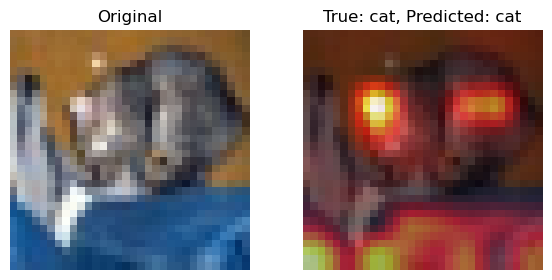

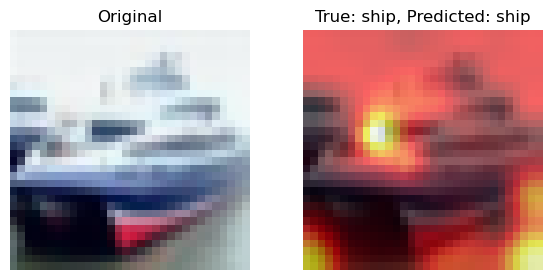

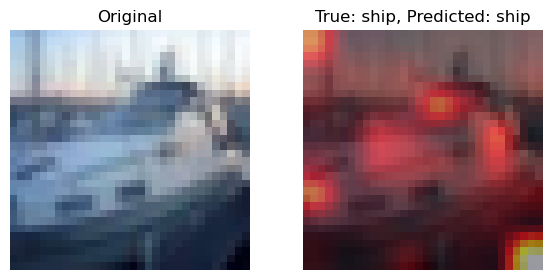

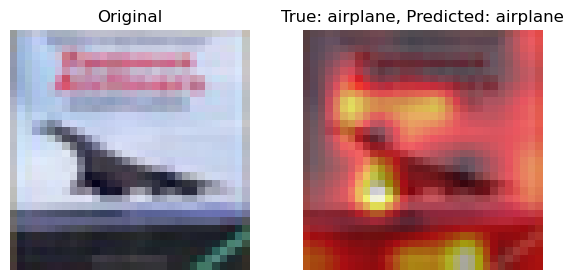

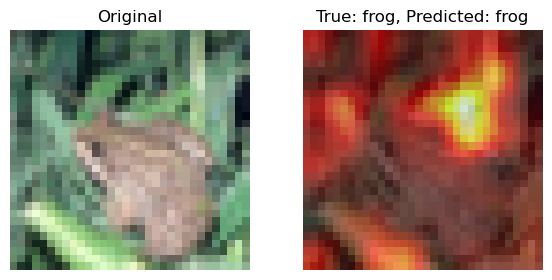

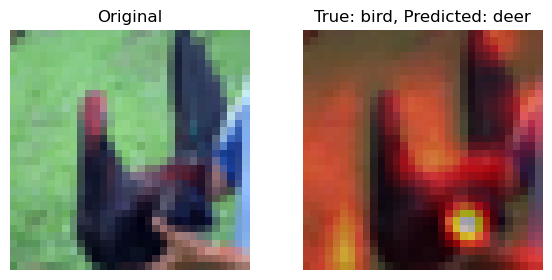

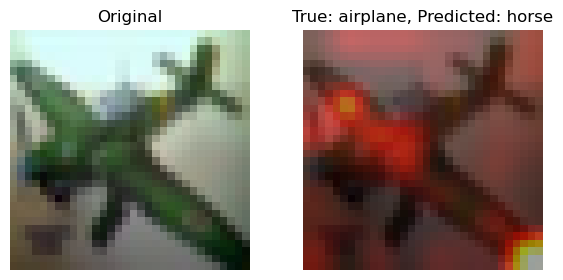

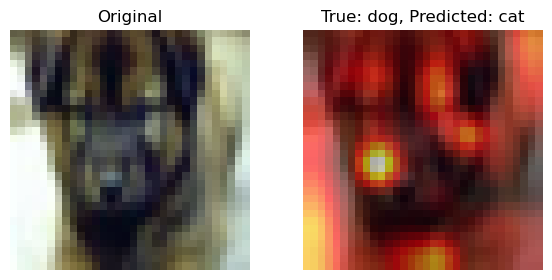

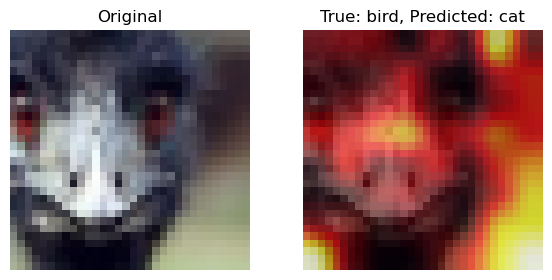

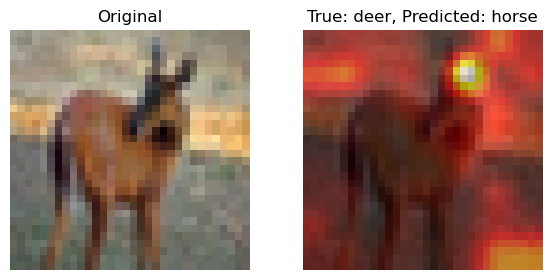

([tensor([[[-0.4018, -0.9099, -0.1478,  ..., -0.1636, -0.1319, -0.1636],
           [-0.4653, -0.1636, -0.0049,  ..., -0.0843, -0.0684, -0.1160],
           [-0.0684, -0.0208,  0.0428,  ..., -0.0684, -0.0843, -0.0684],
           ...,
           [-0.3065, -0.2907, -0.2589,  ...,  1.1383,  0.9954,  0.8366],
           [-0.2907, -0.2589, -0.1954,  ...,  0.9954,  1.2018,  1.2176],
           [-0.5764, -0.0843, -0.0049,  ..., -0.0208,  0.3762,  0.5508]],
  
          [[-0.3215, -0.5147,  0.6287,  ...,  0.8220,  0.8059,  0.7576],
           [-0.0477,  0.5321,  0.8381,  ...,  0.8381,  0.8220,  0.7898],
           [ 0.7576,  0.9508,  1.0797,  ...,  0.8703,  0.8542,  0.8542],
           ...,
           [ 0.4516,  0.4838,  0.5643,  ...,  0.1295,  0.2422,  0.7737],
           [ 0.5321,  0.4838,  0.5965,  ...,  0.0328,  0.3066,  0.5804],
           [ 0.2744,  0.5965,  0.4355,  ..., -0.5147, -0.1443, -0.0316]],
  
          [[-0.5975, -0.7324, -0.0728,  ..., -0.2227, -0.1178, -0.0878],
           

In [71]:
vit_checkpoint_path = "ViT-CIFAR10-Improved\\qwnh2zvl\\checkpoints\\vit-best-run-run=00-epoch=27-val_acc=0.7137.ckpt"
model = ViTLightningModule.load_from_checkpoint(vit_checkpoint_path)
# Visualize attention for test images
visualize_attention_for_batch(model.model, test_loader, num_images=5, 
                             correct_only=True)

# Visualize incorrect predictions
visualize_attention_for_batch(model.model, test_loader, num_images=5, 
                             incorrect_only=True)
